# Advanced EDA of the Dominion Power Hourly MegaWatt Usage

---

In the `eda_initial.ipynb`, I derived a model that was *okay*, but there are ways I could improve it.

Here are some ideas that I explore and implement in this notebook to arrive at a better machine learning model.

### Ways to Improve The Previous Model


* If you noticed in original boxplots, I had a bunch of outliers, so `outlier removal`. Why? Because:
    * outliers can significantly skew the mean, standard deviation, and other statistical measures, making it difficult to draw meaningful conclusions about the data distribution.

    * outliers reduce model accuracy because they can mislead the model during training, causing it to learn incorrect patterns or overfit the data which results in a model that performs poorly on unseen data because it has been trained on a distorted representation of the underlying relationship.

* Identify a `Forecasting Horizon`
    * A forecast horizon refers to the length of time into the future for which a forecast is prepared. Basically, how far into the future will I look to make predictions. 

* I did not perform any cross validation to bear out performance, so I will perform `Time Series cross validation`
    * Cross validation helps to better assess the performance of the model.
    * It involves splitting the data into multiple subsets, training the model on some subsets, and then evaluating it on the remaining subsets. This process is repeated multiple times with different subsets, and the results are averaged to provide a more robust estimate of the model's generalization ability (i.e., the model's ability to perform on new, unseen data). 

* Looking at `lag features`, the past values of a variable used to predict future values. 
    * Lags help the model understand how past events influence current and future outcomes. For example, when predicting stock prices, the previous day's stock price can be used as a lag feature to predict the next day's price. 
    
    * A lag feature is created by shifting the time series data by a certain number of time steps (the lag). For example, a lag of 1 would use the previous day's value to predict the current day's value. 

## Import Key Modules

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

In [96]:
# Using specific styles 
plt.style.use("fivethirtyeight")
color_palette = sns.color_palette("tab10") #seaborn color palette

---

### Perform `Data Ingestion`

Here, I am simply reading the data from the csv file into a dataframe and setting the first column in the csv, `Datetime` to be the index value.

In [97]:
data_file_path = "/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/data/DOm_hourly.csv"

In [98]:
raw_df = pd.read_csv(data_file_path)
df = raw_df.set_index("Datetime")
df.index = pd.to_datetime(df.index) #convert index from string to datatime type

---

# Data Analysis

In [99]:
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116189 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DOM_MW  116189 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [101]:
# check for nulls
df.isnull().sum() # result is that there are no null values 

DOM_MW    0
dtype: int64

In [102]:
# Let's get some stats
df.describe() 

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


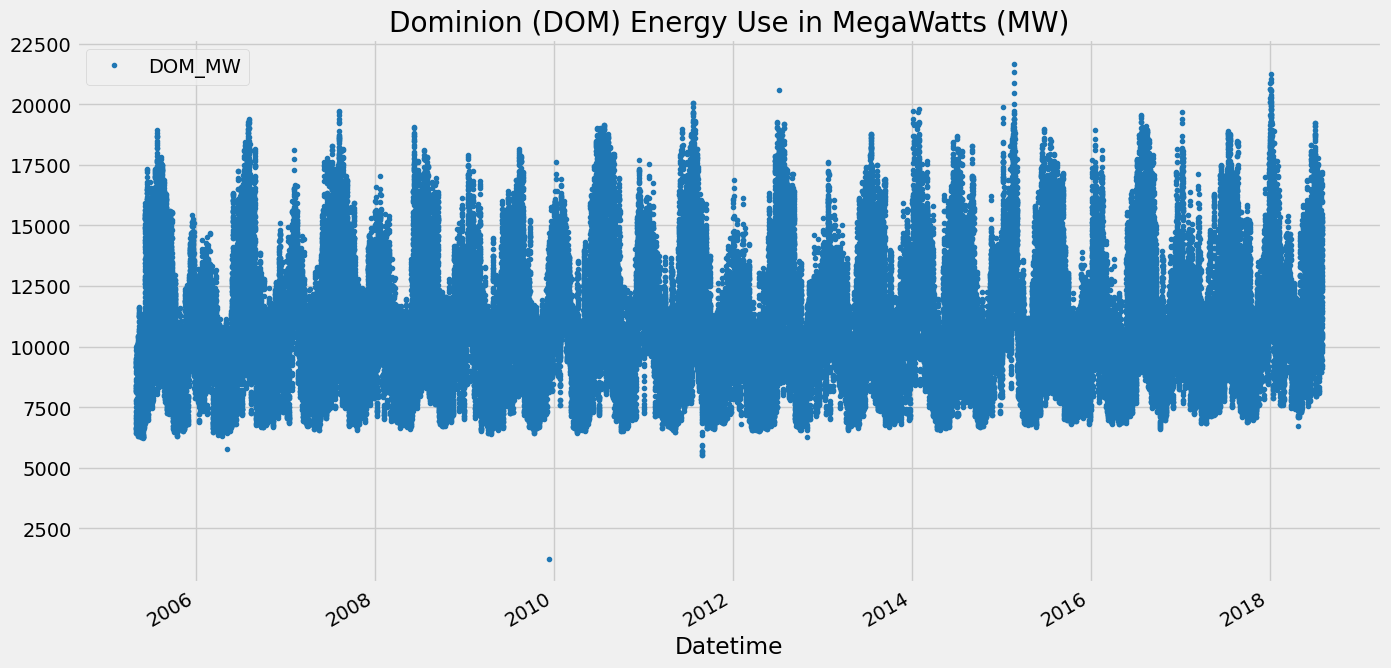

In [103]:
# Initial visualization of the Raw Dataframe

df.plot(
    style = ".",
    figsize = (15, 8),
    color = color_palette[0],
    title = "Dominion (DOM) Energy Use in MegaWatts (MW)"
)
plt.show()

## Outlier Analysis and Removal

Notice in the figure above that we have some data points that are really low and really high especially if we consider the 
statistics presented below:

```
count	116189.000000
mean	10949.203625
std	2413.946569
min	1253.000000
25%	9322.000000
50%	10501.000000
75%	12378.000000
max	21651.000000
```

The model will learn on these outliers, so they have got to go!



In [104]:
# Calculating Tukey Box Plots Whiskers for Outlier Removal
# Note, I do not use Adjusted box plots which can provide better performance for skewed distributions
# as the histogram is not so skewed (see figure below).
mean = 10949
std =  	2414
q1 = 9322
q2 = 12378

iqr = q2 - q1
low_whisker = q1 - (1.5 *iqr)
high_whisker = q2 + (1.5 * iqr)

print(f"low_whisker = {low_whisker}")
print(f"high_whisker = {high_whisker}")

low_whisker = 4738.0
high_whisker = 16962.0


<Axes: ylabel='Frequency'>

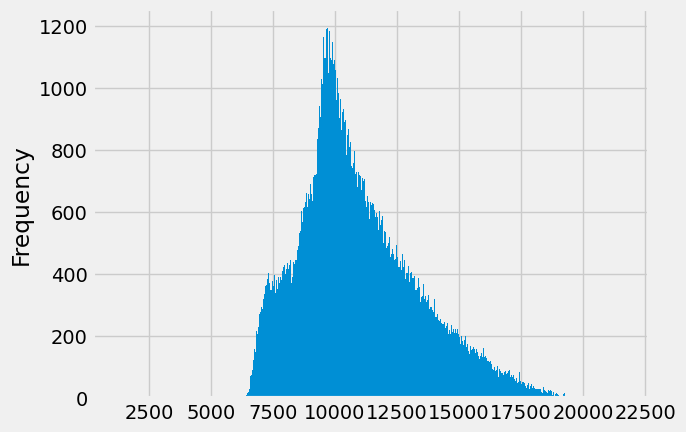

In [105]:
# Lets look at a histogram of our data to get a visual of the distribution
df["DOM_MW"].plot(kind="hist", bins=500)

<Axes: xlabel='Datetime'>

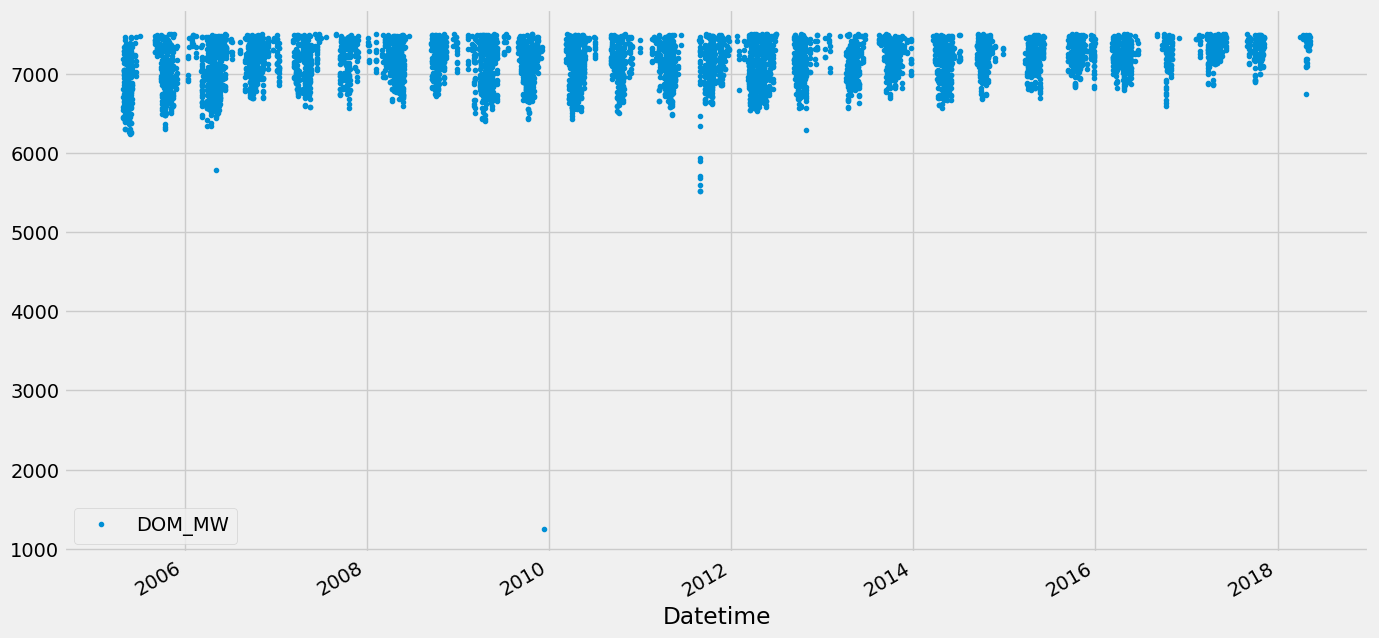

In [106]:
# I identify the lows say anything lower than 7500 the left point in my histogram
# use pandas dataframe query tool to query the column of the data frame with filter term
df.query("DOM_MW < 7500").plot(figsize= (15,8), style = '.')

<Axes: title={'center': 'Lower Value Outliers'}, xlabel='Datetime'>

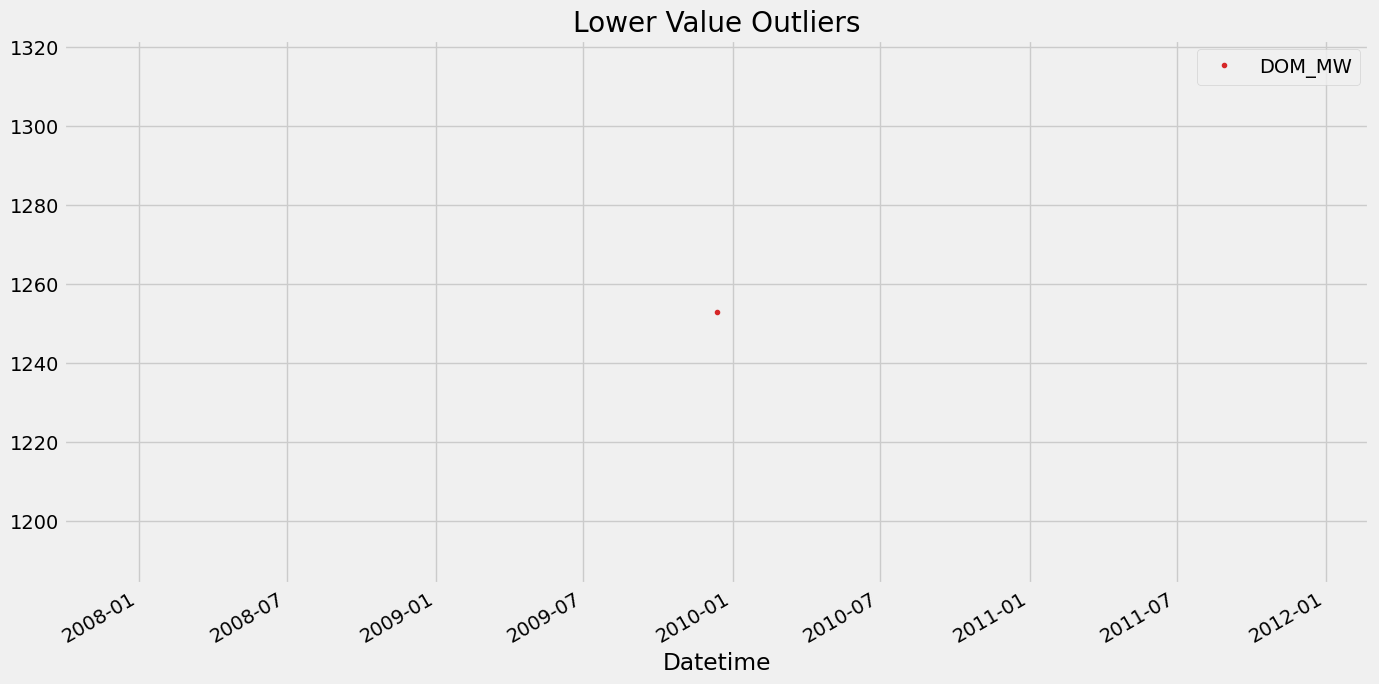

In [107]:
# Looks like from the figure above I can go a little bit tighter and filter at the Tukey low whisker
df.query(f"DOM_MW < {low_whisker}").plot(
    figsize = (15,8), 
    style = '.',
    color = color_palette[3],
    title = "Lower Value Outliers"
)

<Axes: title={'center': 'High Value Outliers'}, xlabel='Datetime'>

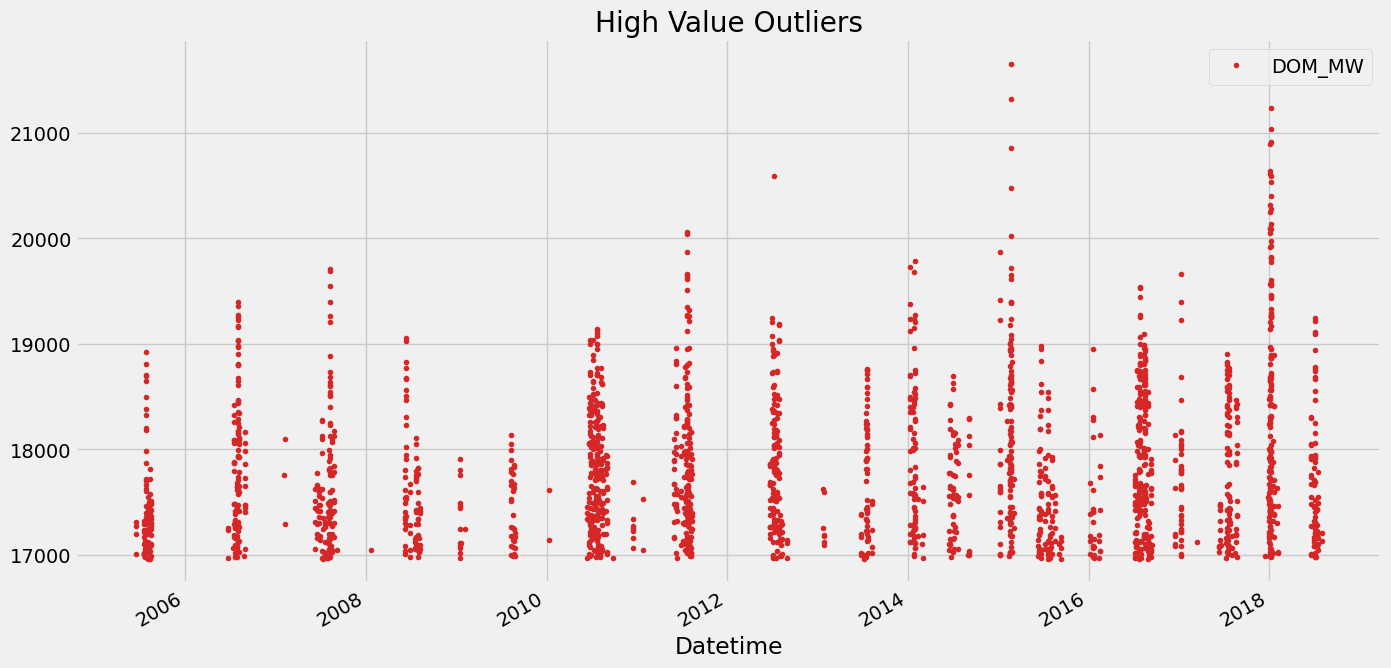

In [108]:
# Now having a look at values on the high side -- Tukey high whisker
df.query(f"DOM_MW > {high_whisker}").plot(
    figsize = (15,8), 
    style = '.',
    color = color_palette[3],
    title = "High Value Outliers"
)

In [109]:
#Apply some filtering here to our data set to remove outliers
df = df.query(f"DOM_MW >= {low_whisker} and DOM_MW <= {high_whisker}").copy()

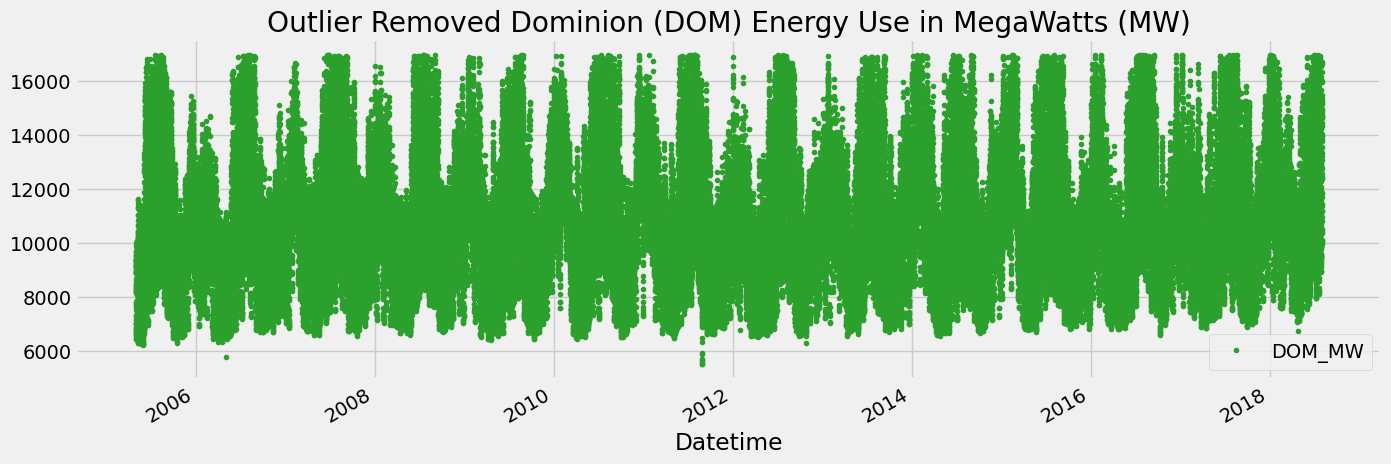

In [110]:
#  Visualization of the Outlier Removed Dataframe

df.plot(
    style = ".",
    figsize = (15, 5),
    color = color_palette[2],
    title = "Outlier Removed Dominion (DOM) Energy Use in MegaWatts (MW)"
)
plt.show()

---

# Set-up Training Data for Learning Model

#### This time using `Time Series Cross Validation` 

We ensure we are not `leaking` data by moving validation set in each fold. Data leakage in cross validation happens when the model is trained on data that includes information from the validation or test set, which it would not have access to during deployment. This leakage can happen due to improper data splitting, preprocessing, or feature engineering. 

In [111]:
time_series_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #One year 24*365*1
df = df.sort_index() # Sort data frame on the time series

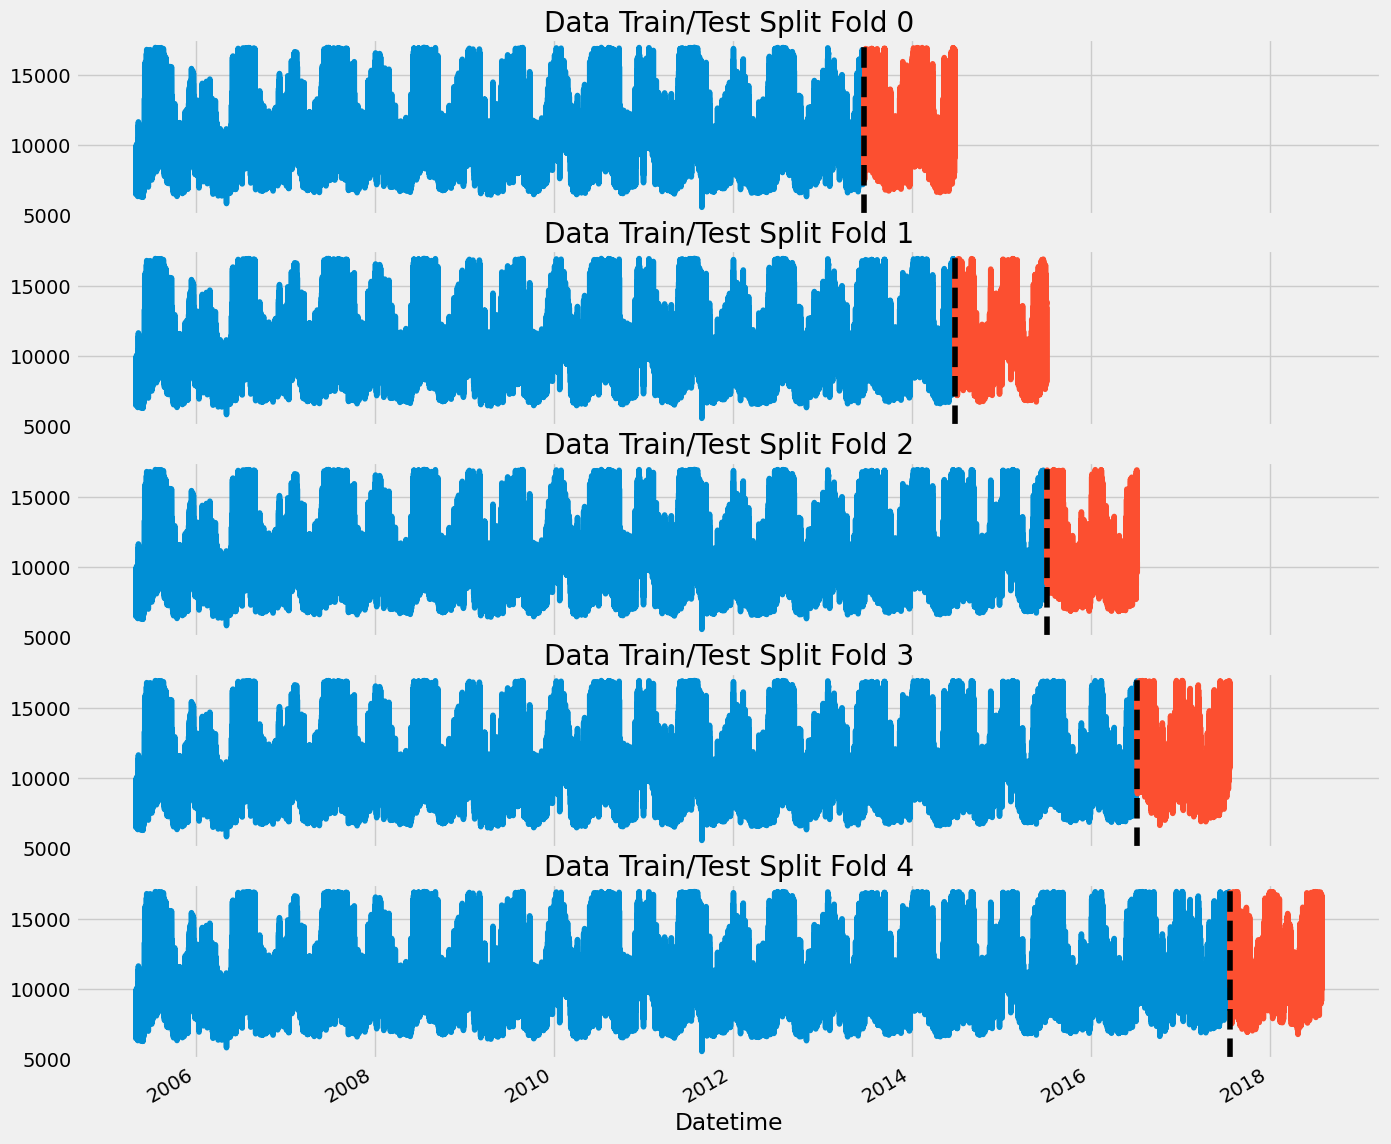

In [112]:
# Visualize Training and Test Data With Cross Validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True) #sharex says share the x-axis

fold = 0
for train_index, val_index in time_series_split.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train["DOM_MW"].plot(ax=axs[fold],
                          label="Training Set",
                          title=f"Data Train/Test Split Fold {fold}")
    test["DOM_MW"].plot(ax=axs[fold],
                         label="Test Set")
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Now to Perform Forecasting Horizon

The forecast horizon is the length of time into the future to perform forecasts.

Examples:
* A year from now
* Two years from now
* Three years from now

### Create Features

In [113]:
# Function to create features on days, months, quarters, weeks, and years fo the data set
def create_features(df: pd.DataFrame) -> pd.DataFrame:
  """
  Create time series features based on time series index.
  """
  df = df.copy() #Make deep copy so changes will be done to the copy
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek #in pandas Monday = 0 and Sunday = 6
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week
  return df

df = create_features(df)

### Creating Lag Features

I want to look at what was the target Z-days in the past. 

Here, I Use the target value at the lag (i.e., "DOM_MW" value in this case) as a new feature.

Note, I can't add lag features back further than my time horizon. So for example, I would not be able to  find values a year back from say the earliest year. I show this point in a few cells below



In [114]:
# Create a dictionary to help map lag features onto our dataframe
df["DOM_MW"].to_dict(); # makes dict key:datetime value:DOM_MW

In [115]:
# use 364 to make the math easier for mapping days 364/7 = 52
df.index - pd.Timedelta("364 days")

DatetimeIndex(['2004-05-02 01:00:00', '2004-05-02 02:00:00',
               '2004-05-02 03:00:00', '2004-05-02 04:00:00',
               '2004-05-02 05:00:00', '2004-05-02 06:00:00',
               '2004-05-02 07:00:00', '2004-05-02 08:00:00',
               '2004-05-02 09:00:00', '2004-05-02 10:00:00',
               ...
               '2017-08-03 15:00:00', '2017-08-03 16:00:00',
               '2017-08-03 17:00:00', '2017-08-03 18:00:00',
               '2017-08-03 19:00:00', '2017-08-03 20:00:00',
               '2017-08-03 21:00:00', '2017-08-03 22:00:00',
               '2017-08-03 23:00:00', '2017-08-04 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=114083, freq=None)

In [116]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add lag features to dataframe
    Can't be longer than Forecasting Horizon
    """
    target_map = df["DOM_MW"].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # one year this lag is my limit
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # two years
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # three years
    return df
    

In [117]:
# Add lag feature columns to the dataframe
df = add_lags(df)

In [118]:
df.head() #should see NAN's for all three lags especially for the earliest day of year

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2005-05-01 01:00:00,7190.0,1,6,2,5,2005,121,1,17,NaN,NaN,NaN
2005-05-01 02:00:00,6803.0,2,6,2,5,2005,121,1,17,NaN,NaN,NaN
2005-05-01 03:00:00,6583.0,3,6,2,5,2005,121,1,17,NaN,NaN,NaN
2005-05-01 04:00:00,6452.0,4,6,2,5,2005,121,1,17,NaN,NaN,NaN
2005-05-01 05:00:00,6445.0,5,6,2,5,2005,121,1,17,NaN,NaN,NaN


In [119]:
df.tail() # see non NaN's for the later years because I can't go back 3 years. Here is the horizon constraint mentiond above

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,14038.0,20,3,3,8,2018,214,2,31,15364.0,14257.0,13804.0
2018-08-02 21:00:00,13832.0,21,3,3,8,2018,214,2,31,14826.0,13870.0,13519.0
2018-08-02 22:00:00,13312.0,22,3,3,8,2018,214,2,31,14047.0,13405.0,12827.0
2018-08-02 23:00:00,12390.0,23,3,3,8,2018,214,2,31,12915.0,12258.0,11785.0
2018-08-03 00:00:00,11385.0,0,4,3,8,2018,215,3,31,11607.0,11153.0,10717.0


----

# Creating the XGBoost Model - Using Cross Validation During Training and with New Features.

I take advantage of `from sklearn.model_selection import TimeSeriesSplit`


In [120]:
time_series_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #One year 24*365*1
df = df.sort_index() # Sort data frame on the time series

In [121]:
fold = 0
preds = []
scores = []
for train_index, val_index in time_series_split.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ["dayofyear", "hour", "dayofweek", "quarter", "month", "year",
                "lag1", "lag2", "lag3"]
    TARGET = "DOM_MW"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10829.97485	validation_1-rmse:11155.94019
[100]	validation_0-rmse:4214.66435	validation_1-rmse:4489.21874


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2035.13460	validation_1-rmse:2296.96186
[300]	validation_0-rmse:1450.76298	validation_1-rmse:1682.90182
[400]	validation_0-rmse:1313.09402	validation_1-rmse:1540.69022
[500]	validation_0-rmse:1271.03565	validation_1-rmse:1507.49909
[600]	validation_0-rmse:1246.42774	validation_1-rmse:1490.93681
[700]	validation_0-rmse:1225.56587	validation_1-rmse:1474.83036
[800]	validation_0-rmse:1212.09622	validation_1-rmse:1473.08134
[801]	validation_0-rmse:1212.02953	validation_1-rmse:1473.06173
[0]	validation_0-rmse:10865.40701	validation_1-rmse:11200.28817
[100]	validation_0-rmse:4227.96292	validation_1-rmse:4490.06948


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:05:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2047.44099	validation_1-rmse:2256.10846
[300]	validation_0-rmse:1469.91261	validation_1-rmse:1615.86520
[400]	validation_0-rmse:1334.83897	validation_1-rmse:1448.66818
[500]	validation_0-rmse:1295.14429	validation_1-rmse:1406.00418
[600]	validation_0-rmse:1274.17155	validation_1-rmse:1393.23637
[700]	validation_0-rmse:1257.58832	validation_1-rmse:1390.64011
[800]	validation_0-rmse:1245.15287	validation_1-rmse:1388.17423
[900]	validation_0-rmse:1232.58819	validation_1-rmse:1384.45596
[999]	validation_0-rmse:1221.62242	validation_1-rmse:1383.13113
[0]	validation_0-rmse:10899.79541	validation_1-rmse:10802.61921
[100]	validation_0-rmse:4239.29556	validation_1-rmse:4011.71841


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:05:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2054.33902	validation_1-rmse:1817.91021
[300]	validation_0-rmse:1481.41382	validation_1-rmse:1352.28342
[398]	validation_0-rmse:1351.61038	validation_1-rmse:1343.55161
[0]	validation_0-rmse:10890.87180	validation_1-rmse:11134.38693
[100]	validation_0-rmse:4234.52094	validation_1-rmse:4481.47472


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2049.78822	validation_1-rmse:2311.89471
[300]	validation_0-rmse:1477.18563	validation_1-rmse:1761.48167
[400]	validation_0-rmse:1349.48519	validation_1-rmse:1672.51173
[500]	validation_0-rmse:1312.31606	validation_1-rmse:1667.19779
[600]	validation_0-rmse:1290.79496	validation_1-rmse:1669.78143
[615]	validation_0-rmse:1288.13872	validation_1-rmse:1674.06512
[0]	validation_0-rmse:10910.74056	validation_1-rmse:11336.92303
[100]	validation_0-rmse:4245.99588	validation_1-rmse:4594.17079


/Users/lancehester/Documents/ts_forecasting_project_first_energy_mw/.venv/lib/python3.13/site-packages/xgboost/callback.py:386: UserWarning: [00:05:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:2061.88006	validation_1-rmse:2324.78153
[300]	validation_0-rmse:1491.80597	validation_1-rmse:1720.56534
[400]	validation_0-rmse:1367.63926	validation_1-rmse:1580.32712
[500]	validation_0-rmse:1330.62864	validation_1-rmse:1549.56945
[600]	validation_0-rmse:1312.54382	validation_1-rmse:1541.19406
[690]	validation_0-rmse:1298.03904	validation_1-rmse:1539.15365


In [122]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores: {scores}")

Score across folds 1478.3992
Fold scores: [np.float64(1472.9743383855453), np.float64(1382.9897255406202), np.float64(1332.1156726684155), np.float64(1664.8638622869003), np.float64(1539.0525979082836)]


# Comparison of the RSME Score with this New Model Vs The original

* Original Model - RMSE Score on Test set: 1627.86
* Optimized Model - RMSE Score on Test set: 1478.3992 (mean score) 

The optimized model has a lower RSME score which says we have improved our model from `eda_initial.ipynb`!

###  Forecasting Using the Test Data with New Model

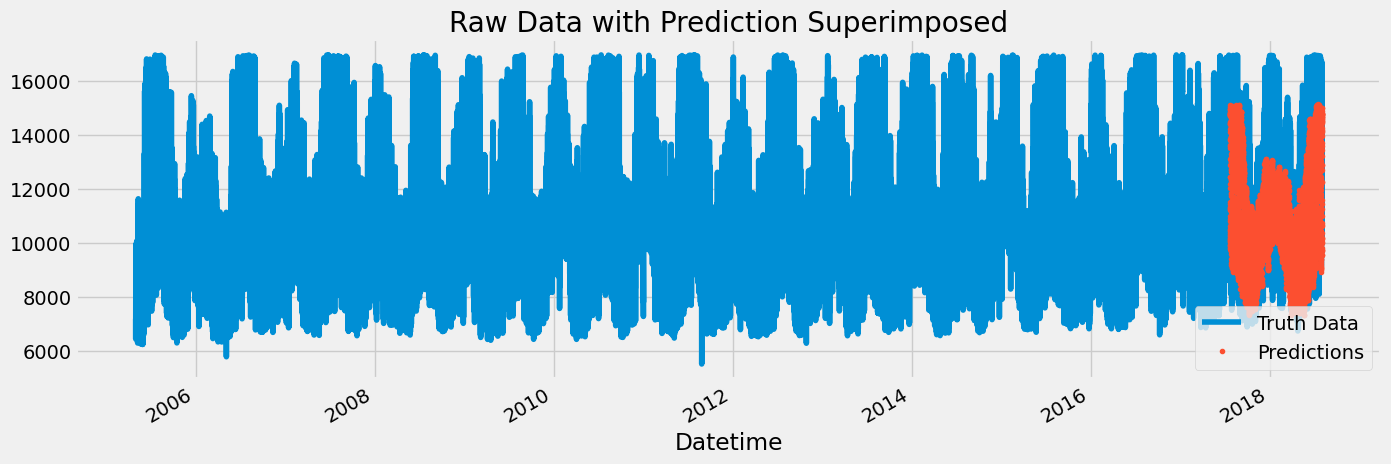

In [123]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[["DOM_MW"]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(["Truth Data", "Predictions"])
ax.set_title("Raw Data with Prediction Superimposed")
plt.show()

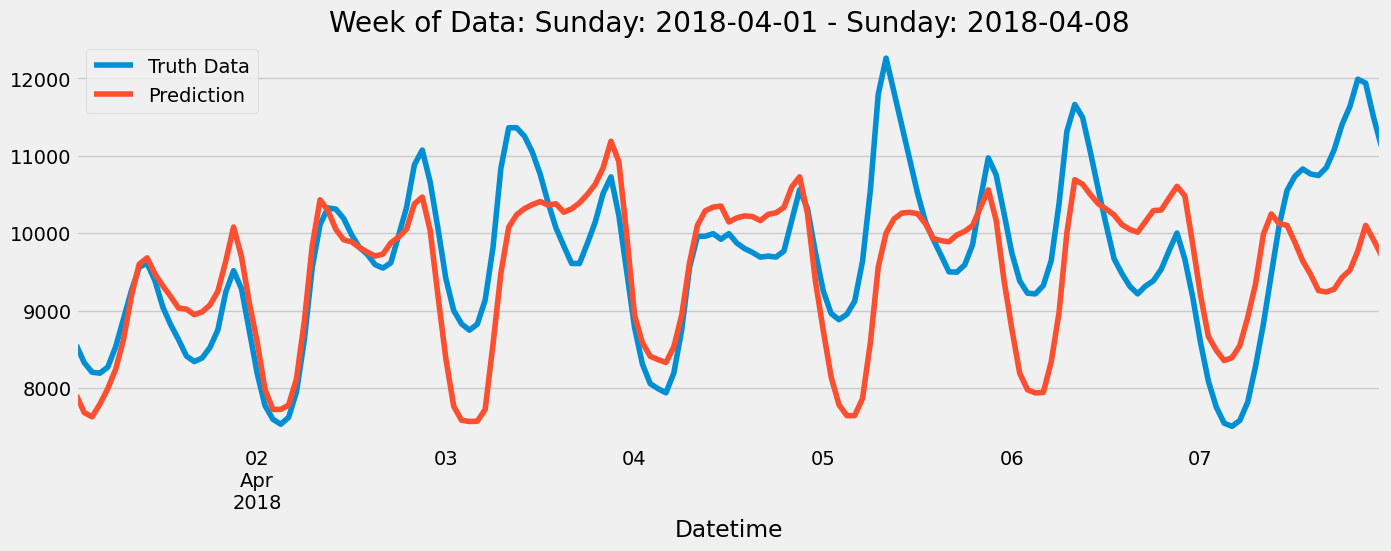

In [124]:
# Looking at a weeks worth of data
df_week_test = df.loc[(df.index > "2018-04-01") & (df.index < "2018-04-08")]
df_week_test = df_week_test.sort_values(by="Datetime") # wee need to sort to make sure we don't have overlaps in the data

ax = df_week_test["DOM_MW"].plot(figsize=(15, 5), title="Week of Data: Sunday: 2018-04-01 - Sunday: 2018-04-08")
df_week_test["prediction"].plot(style='-')
plt.legend(["Truth Data","Prediction"])
plt.show()

The figures above reveal that the new model does a better job of predicting that the previous non-optimized model.

## Creating a future Dataframe for testing

In [125]:
# Get the last timestamp of the current data set to help build future DataFrame 
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [126]:
# Create future dataframe
future = pd.date_range("2018-08-03","2019-08-01", freq="1h") #need hourly intervals freq=1h
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True #Helps to distinquish future values for testing
df["isFuture"] = False  #Helps to distinquish future values for testing
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [127]:
df.head()

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction,isFuture
Datetime,,,,,,,,,,,,,,
2005-05-01 01:00:00,7190.0,1,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 02:00:00,6803.0,2,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 03:00:00,6583.0,3,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 04:00:00,6452.0,4,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 05:00:00,6445.0,5,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False


In [128]:
future_df.head()

,isFuture
2018-08-03 00:00:00,True
2018-08-03 01:00:00,True
2018-08-03 02:00:00,True
2018-08-03 03:00:00,True
2018-08-03 04:00:00,True


In [129]:
df_and_future.head()

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction,isFuture
2005-05-01 01:00:00,7190.0,1,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 02:00:00,6803.0,2,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 03:00:00,6583.0,3,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 04:00:00,6452.0,4,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False
2005-05-01 05:00:00,6445.0,5,6,2,5,2005,121,1,17,NaN,NaN,NaN,NaN,False


In [130]:
future_w_features = df_and_future.query('isFuture').copy()

In [131]:
future_w_features.head() # see no target DOM_NW data

,DOM_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,11607.0,11153.0,10717.0,NaN,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,10638.0,10229.0,9874.0,NaN,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,9971.0,9659.0,9384.0,NaN,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,9613.0,9285.0,8998.0,NaN,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,9381.0,9094.0,8834.0,NaN,True


### Predicting Future Values to Add to `future_w_features`

In [132]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

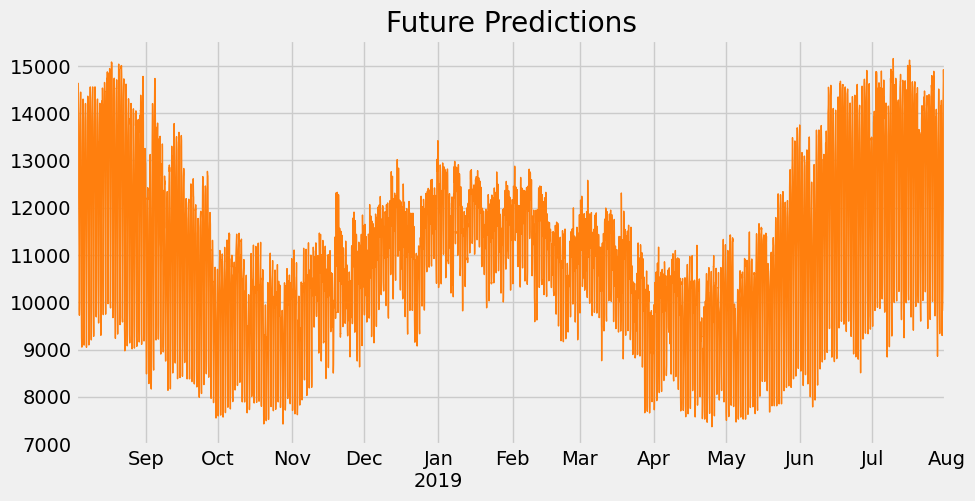

In [133]:
#Future predictions for the new 2019 year

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_palette[1],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

---

## Saving the Model and Future Prediction Data Frame to Be used Elsewhere

Here, I save the model to be used for a web application. 

---

In [134]:
# Save model
reg.save_model('model.json')

In [136]:
# moving to 
future_w_features.to_csv("future_values.csv", index=True, header=True)


---

# Check to see that I can load the model for use

Here, I just want to verify that I can load up the model I created earlier. 

---

<Axes: title={'center': 'Future Predictions'}>

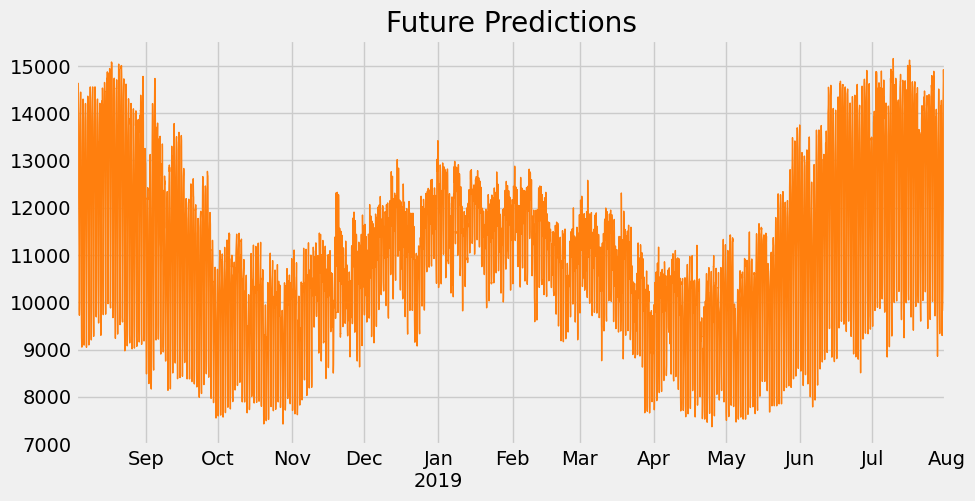

In [137]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("model.json")
future_w_features["pred"] = reg_new.predict(future_w_features[FEATURES])
future_w_features["pred"].plot(figsize=(10, 5),
                               color=color_palette[1],
                               ms=1, lw=1,
                               title='Future Predictions')

<Axes: title={'center': 'Future Predictions'}, xlabel='Datetime'>

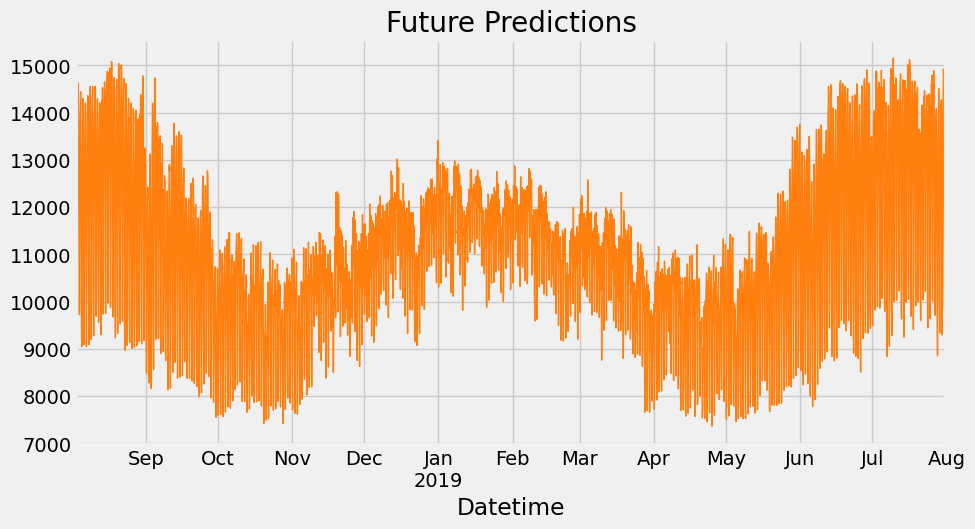

In [148]:
# Test to make sure able to input future test data file and render same results 
future_values_df = pd.read_csv("future_values.csv")

#Convert first column to get datetime
old_name = future_values_df.columns[0]
future_values_df = future_values_df.rename(columns={old_name:"Datetime"})

future_values_df = future_values_df.set_index("Datetime")
future_values_df.index = pd.to_datetime(future_values_df.index) #convert index from string to datatime type

reg_new2 = xgb.XGBRegressor()
reg_new2.load_model("model.json")
future_values_df["pred"] = reg_new2.predict(future_values_df[FEATURES])
future_values_df["pred"].plot(figsize=(10, 5),
                               color=color_palette[1],
                               ms=1, lw=1,
                               title='Future Predictions')